# Preparation Agent
This notebook is dedicated to the data extraction and basic preparation done in the notebook 'Preparation Agent'. We start by installing dependencies that we need.
As previously, Helper functions will be used. Available on GitHub.

In [83]:
import pandas as pd
import numpy as np
import os
dir = 'D:/Master BWL HU/3. Semester/Seminar Information Systems/Seminar-Information-Systems-main'
os.chdir(dir)

from helper_functions import Helper
from agents import Preparation_Agent
import pandas as pd

helper = Helper()

dbfile  = "D:/Master BWL HU/3. Semester/Seminar Information Systems/Seminar-Information-Systems-main/home-assistant_Chris_v3.db"

The helper functions will be used as in the previous works. Available at GitHub

### SQL Data Pulling

I removed the code for other databases as we will stick to the one called 'states'. In my own database I see states and attributes in different databases. 
<font color='red'>Check with Alona how she managed to put them together. And which version do we use? Did she send us updated data?
</font> 
For now databases will be in the same form as in the first Alona's file.

Note, initialization function contains also the function for SQL Pulling. <font color='red'> If you have any optimization ideas, please bring it in! </font>

In [84]:
class Preparation_Agent:
    import pandas as pd
    helper = Helper()
    def __init__(self, dbfile, shiftable_devices):
        self.input = helper.export_sql(dbfile)
        self.shiftable_devices = shiftable_devices

In [85]:
shiftable_devices = ["sensor.shellyplug_s_4022d88961b4_power", "sensor.shellyplug_s_4022d88984b8_power"]

In [86]:
prep = Preparation_Agent(dbfile, shiftable_devices)
prep.input.head()

,state_id,entity_id,state,attributes,event_id,last_changed,last_updated,old_state_id,attributes_id,context_id,context_user_id,context_parent_id,origin_idx,hash,shared_attributes
0,1,update.home_assistant_supervisor_update,off,None,None,None,2022-12-25 18:18:34.594923,NaN,1,01GN5842Q23HBMB7EZ6KY9A13R,None,None,0,2939789592,"{""auto_update"":true,""installed_version"":""2022...."
1,2,update.home_assistant_core_update,off,None,None,None,2022-12-25 18:18:34.595605,NaN,2,01GN5842Q3P07WA0KC0S4WMRZ4,None,None,0,2651871198,"{""auto_update"":false,""installed_version"":""2022..."
2,3,update.home_assistant_operating_system_update,off,None,None,None,2022-12-25 18:18:34.596293,NaN,3,01GN5842Q4738MTF23J7WJFNA8,None,None,0,2287136131,"{""auto_update"":false,""installed_version"":""9.4""..."
3,4,sun.sun,below_horizon,None,None,None,2022-12-25 18:18:34.969050,NaN,4,01GN58432SXZ8BV6NEGP0NDMQF,None,None,0,1454287034,"{""friendly_name"":""Sun""}"
4,5,zone.home,0,None,None,None,2022-12-25 18:18:34.971450,NaN,5,01GN58432VZ0634BF3S40SSSPA,None,None,0,1858961947,"{""latitude"":0,""longitude"":0,""radius"":100,""pass..."


In [87]:
prep.input["shared_attributes"][1]

'{"auto_update":false,"installed_version":"2022.12.8","latest_version":"2022.12.8","release_url":"https://www.home-assistant.io/latest-release-notes/","skipped_version":null,"title":"Home Assistant Core","friendly_name":"Home Assistant Core Update"}'

### Data Unpacking
We received data frame that has dictionaries in column value. In this section, we bring the data frame to the wide format, additionally unpacking the column. After that I specify that I need values in kWh and choose nodes. <font color='red'>Note: user should specify the nodes. How does he do it? Is kWh okay?
</font>

Here I am dropping values but it is not sustainable solution.

In [88]:
#adapted for HA
def unpacking_attributes(self, df):
    output = df.copy()
    output['shared_attributes']=output['shared_attributes'].apply(lambda x: x.replace('true','True'))
    output['shared_attributes']=output['shared_attributes'].apply(lambda x: x.replace('false','False'))
    output['shared_attributes']=output['shared_attributes'].apply(lambda x: x.replace('null','None'))

    output['shared_attributes']=output['shared_attributes'].apply(lambda dat: dict(eval(dat)))
    df2 = pd.json_normalize(output['shared_attributes'])
    result = pd.DataFrame( pd.concat([output,df2], axis = 1).drop('shared_attributes', axis = 1))
    result = result.dropna(axis = 1, thresh=int(0.95*(len(result.columns))))
    return result

setattr(Preparation_Agent, 'unpacking_attributes', unpacking_attributes)
del unpacking_attributes

In [89]:
data_unpacked  = prep.unpacking_attributes(prep.input)


In [90]:
data_unpacked

,state_id,entity_id,state,last_changed,last_updated,old_state_id,attributes_id,context_id,origin_idx,hash,...,popularity_thursday,popularity_friday,popularity_saturday,popularity_sunday,gps_accuracy,altitude,course,vertical_accuracy,source,visibility
0,1,update.home_assistant_supervisor_update,off,None,2022-12-25 18:18:34.594923,NaN,1,01GN5842Q23HBMB7EZ6KY9A13R,0,2939789592,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,2,update.home_assistant_core_update,off,None,2022-12-25 18:18:34.595605,NaN,2,01GN5842Q3P07WA0KC0S4WMRZ4,0,2651871198,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,3,update.home_assistant_operating_system_update,off,None,2022-12-25 18:18:34.596293,NaN,3,01GN5842Q4738MTF23J7WJFNA8,0,2287136131,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,4,sun.sun,below_horizon,None,2022-12-25 18:18:34.969050,NaN,4,01GN58432SXZ8BV6NEGP0NDMQF,0,1454287034,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,5,zone.home,0,None,2022-12-25 18:18:34.971450,NaN,5,01GN58432VZ0634BF3S40SSSPA,0,1858961947,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
48052,48053,sensor.bogenleuchte,3.64,None,2023-01-09 16:04:03.304076,48047.0,3187,01GPBMCHK8NKZ9BDN58J2R4VR7,0,119982377,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
48053,48054,sensor.olaf,3.02,None,2023-01-09 16:04:04.365858,48048.0,3190,01GPBMCJMDFRDAMRBF5VH03ZH2,0,1243904514,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
48054,48055,sensor.blub,3.02,None,2023-01-09 16:04:07.163404,48049.0,3189,01GPBMCNBVQG0WZZBYZK2FPCRN,0,1905492863,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
48055,48056,sensor.bogenleuchte,3.66,None,2023-01-09 16:05:03.304884,48053.0,3187,01GPBMEC68DB8P98M3AQ9KNE4B,0,119982377,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


Attributes ID is not unique for one entity, therefore we use entity_id to identify the different sensors

In [101]:
data_unpacked.loc[data_unpacked['entity_id'] == "sensor.shellyplug_s_4022d88984b8_power"].attributes_id.unique()

array([42, 46, 49, 59, 60, 78, 65], dtype=int64)

In [91]:
data_unpacked.unit_of_measurement.unique()

array([nan, '%', 'W', 'kWh', '°C', 'gCO2eq/kWh', 'pending update(s)',
       'MB', 'h', 'm', 'mm', 'UV index', 'km/h'], dtype=object)

In [10]:
W_data = data_unpacked[data_unpacked.unit_of_measurement=='W']
W_data

,state_id,entity_id,state,last_changed,last_updated,old_state_id,attributes_id,context_id,origin_idx,hash,...,popularity_thursday,popularity_friday,popularity_saturday,popularity_sunday,gps_accuracy,altitude,course,vertical_accuracy,source,visibility
44,45,sensor.shellyplug_s_4022d88984b8_power,0.0,None,2022-12-25 18:23:02.912953,NaN,42,01GN58C8R0C9YYBN4WNNR60FMQ,0,2570095616,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
52,53,sensor.shellyplug_s_4022d88984b8_power,unavailable,None,2022-12-25 18:27:23.058601,45.0,46,01GN58M6SJX8SY5TKMDTN6ZBWY,0,3871410428,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
58,59,sensor.shellyplug_s_4022d88984b8_power,0.0,None,2022-12-25 18:27:23.351347,53.0,42,01GN58M72QX5C8DQTMANND8D2P,0,2570095616,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
62,63,sensor.shellyplug_s_4022d88984b8_power,unavailable,None,2022-12-25 18:30:43.965837,59.0,46,01GN58TAZX06RADXTXG7ZE3YD5,0,3871410428,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
68,69,sensor.shellyplug_s_4022d88984b8_power,0.0,None,2022-12-25 18:30:44.209707,63.0,42,01GN58TB7H7ZSH54AGJWJ4KEYK,0,2570095616,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
47929,47930,sensor.chris_battery_power,0.0,2023-01-09 15:26:05.748234,2023-01-09 15:34:20.894509,47896.0,5427,01GPBJP4YY44FGZYXR1Z3N8RZV,0,3611454642,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
47936,47937,sensor.chris_battery_power,-0.01,None,2023-01-09 15:35:39.146393,47930.0,5428,01GPBJRHCAB88JPJBRE3FYHMDB,0,2691285062,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
47946,47947,sensor.chris_battery_power,0.0,None,2023-01-09 15:37:33.522641,47937.0,5429,01GPBJW12J0K9FC7DQPDEH3371,0,2330935983,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
47965,47966,sensor.chris_battery_power,0.0,2023-01-09 15:37:33.522641,2023-01-09 15:41:06.041219,47947.0,5432,01GPBK2GKS3DQZTM5PYHZ9E6ND,0,1950404492,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [11]:
with pd.option_context('display.max_rows', None, 'display.max_columns', None):  # more options can be specified also
    print(W_data[['last_updated', 'state']])

                     last_updated        state
44     2022-12-25 18:23:02.912953          0.0
52     2022-12-25 18:27:23.058601  unavailable
58     2022-12-25 18:27:23.351347          0.0
62     2022-12-25 18:30:43.965837  unavailable
68     2022-12-25 18:30:44.209707          0.0
74     2022-12-25 18:35:18.703098          0.0
79     2022-12-25 18:36:44.390615  unavailable
85     2022-12-25 18:38:06.089660          1.6
89     2022-12-25 18:38:06.428777          0.5
90     2022-12-25 18:38:21.436321          0.0
94     2022-12-25 18:39:38.113563          0.3
98     2022-12-25 18:39:41.222414          0.4
99     2022-12-25 18:40:26.241975          0.0
101    2022-12-25 18:40:41.242247          0.4
104    2022-12-25 18:41:06.919330          0.4
105    2022-12-25 18:41:26.244926          0.0
107    2022-12-25 18:41:41.242938          0.3
108    2022-12-25 18:41:43.994877          0.0
109    2022-12-25 18:41:56.262044          0.5
110    2022-12-25 18:42:05.648142          0.0
112    2022-1

In [12]:
W_data.columns

Index(['state_id', 'entity_id', 'state', 'last_changed', 'last_updated',
       'old_state_id', 'attributes_id', 'context_id', 'origin_idx', 'hash',
       'auto_update', 'installed_version', 'latest_version', 'title',
       'friendly_name', 'latitude', 'longitude', 'editable', 'icon',
       'device_class', 'id', 'user_id', 'temperature', 'temperature_unit',
       'humidity', 'pressure', 'pressure_unit', 'wind_bearing', 'wind_speed',
       'wind_speed_unit', 'visibility_unit', 'precipitation_unit',
       'state_class', 'unit_of_measurement', 'group_name', 'group_type',
       'name', 'speed', 'brightness', 'is_dynamic', 'min_color_temp_kelvin',
       'max_color_temp_kelvin', 'mode', 'dynamics', 'color_mode', 'hs_color',
       'rgb_color', 'xy_color', 'effect', 'is_hue_group', 'hue_scenes',
       'hue_type', 'lights', 'source_type', 'current', 'voltage',
       'color_temp_kelvin', 'color_temp', 'country_code', 'maps_name',
       'address', 'popularity_is_live', 'popularity_mon

In [13]:
W_data = W_data.iloc[:,0:13]
W_data

,state_id,entity_id,state,last_changed,last_updated,old_state_id,attributes_id,context_id,origin_idx,hash,auto_update,installed_version,latest_version
44,45,sensor.shellyplug_s_4022d88984b8_power,0.0,None,2022-12-25 18:23:02.912953,NaN,42,01GN58C8R0C9YYBN4WNNR60FMQ,0,2570095616,NaN,NaN,NaN
52,53,sensor.shellyplug_s_4022d88984b8_power,unavailable,None,2022-12-25 18:27:23.058601,45.0,46,01GN58M6SJX8SY5TKMDTN6ZBWY,0,3871410428,NaN,NaN,NaN
58,59,sensor.shellyplug_s_4022d88984b8_power,0.0,None,2022-12-25 18:27:23.351347,53.0,42,01GN58M72QX5C8DQTMANND8D2P,0,2570095616,NaN,NaN,NaN
62,63,sensor.shellyplug_s_4022d88984b8_power,unavailable,None,2022-12-25 18:30:43.965837,59.0,46,01GN58TAZX06RADXTXG7ZE3YD5,0,3871410428,NaN,NaN,NaN
68,69,sensor.shellyplug_s_4022d88984b8_power,0.0,None,2022-12-25 18:30:44.209707,63.0,42,01GN58TB7H7ZSH54AGJWJ4KEYK,0,2570095616,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...
47929,47930,sensor.chris_battery_power,0.0,2023-01-09 15:26:05.748234,2023-01-09 15:34:20.894509,47896.0,5427,01GPBJP4YY44FGZYXR1Z3N8RZV,0,3611454642,NaN,NaN,NaN
47936,47937,sensor.chris_battery_power,-0.01,None,2023-01-09 15:35:39.146393,47930.0,5428,01GPBJRHCAB88JPJBRE3FYHMDB,0,2691285062,NaN,NaN,NaN
47946,47947,sensor.chris_battery_power,0.0,None,2023-01-09 15:37:33.522641,47937.0,5429,01GPBJW12J0K9FC7DQPDEH3371,0,2330935983,NaN,NaN,NaN
47965,47966,sensor.chris_battery_power,0.0,2023-01-09 15:37:33.522641,2023-01-09 15:41:06.041219,47947.0,5432,01GPBK2GKS3DQZTM5PYHZ9E6ND,0,1950404492,NaN,NaN,NaN


In [14]:
W_data.entity_id.unique()

array(['sensor.shellyplug_s_4022d88984b8_power',
       'sensor.shellyplug_s_4022d88961b4_power',
       'sensor.sm_g975f_battery_power', 'sensor.yal_l21_battery_power',
       'sensor.chris_battery_power'], dtype=object)

### Accessing only nodes in W
Not optimally written code! However, this function only takes entities that have consumption in kWh and nodes defined by the user. <font color = 'red'> Next question is how to merge it with the home assistant so user can define which node to use? Also tried to get rid of NaN column, why it didn't work out? </font>

In [15]:
#updated
def access_shiftable_devices(self, df, attrs= 'all'):
    trial = df.copy()
    trial.attributes_id = trial.attributes_id.dropna()
    trial.state= pd.to_numeric(trial['state'], errors='coerce').dropna()
    if attrs == 'all':
        w_data = trial[trial.unit_of_measurement.isin(['W'])]
        w_data = trial[trial.entity_id.isin(prep.shiftable_devices)]
        #we can add entity_id, or disregard
        w_data_long = w_data[['entity_id','last_updated','state']]
        w_data_wide = pd.pivot(w_data_long,  index = ['last_updated'], columns = 'entity_id', values = 'state')
    if attrs != 'all':
        w_data = trial[trial.unit_of_measurement.isin(['W']) & trial.attributes_id.isin([attrs])]
        w_data = trial[trial.entity_id.isin(prep.shiftable_devices)]
        w_data_long = w_data[['entity_id','last_updated','state']]
        w_data_wide = pd.pivot(w_data_long,  index = ['last_updated'], columns = 'entity_id', values = 'state')
    result = w_data_wide.fillna(0).reset_index()
    return(result)

setattr(Preparation_Agent, 'access_shiftable_devices', access_shiftable_devices)
del access_shiftable_devices

In [16]:
data_w = prep.access_shiftable_devices(data_unpacked)
data_w.head()

entity_id,last_updated,sensor.shellyplug_s_4022d88961b4_power,sensor.shellyplug_s_4022d88984b8_power
0,2022-12-25 18:23:02.912953,0.0,0.0
1,2022-12-25 18:27:23.058601,0.0,0.0
2,2022-12-25 18:27:23.351347,0.0,0.0
3,2022-12-25 18:30:43.965837,0.0,0.0
4,2022-12-25 18:30:44.209707,0.0,0.0


In [17]:
with pd.option_context('display.max_rows', None, 'display.max_columns', None):  # more options can be specified also
    print(data_w[['last_updated','sensor.shellyplug_s_4022d88984b8_power']])

entity_id                last_updated  sensor.shellyplug_s_4022d88984b8_power
0          2022-12-25 18:23:02.912953                                     0.0
1          2022-12-25 18:27:23.058601                                     0.0
2          2022-12-25 18:27:23.351347                                     0.0
3          2022-12-25 18:30:43.965837                                     0.0
4          2022-12-25 18:30:44.209707                                     0.0
5          2022-12-25 18:35:18.703098                                     0.0
6          2022-12-25 18:36:44.390615                                     0.0
7          2022-12-25 18:38:06.089660                                     1.6
8          2022-12-25 18:38:06.428777                                     0.5
9          2022-12-25 18:38:21.436321                                     0.0
10         2022-12-25 18:39:38.113563                                     0.0
11         2022-12-25 18:39:41.222414                           

### Standard Data Preprocessing - Outlier Truncation
Here comes <font color='red'> the first issue </font>, the consumption which was reported is really low. When we apply outlier truncation, all values that are not zero becoming zeros. Therefore, should we skip outlier truncation step?
I am taking kWh - kilowatt hour. <font color='red'> Do you think I should take W better  </font>? Below one can see that only node 3 and 46 are active and activity is super low. I will create outlier truncation but I do not think that it should be applied.

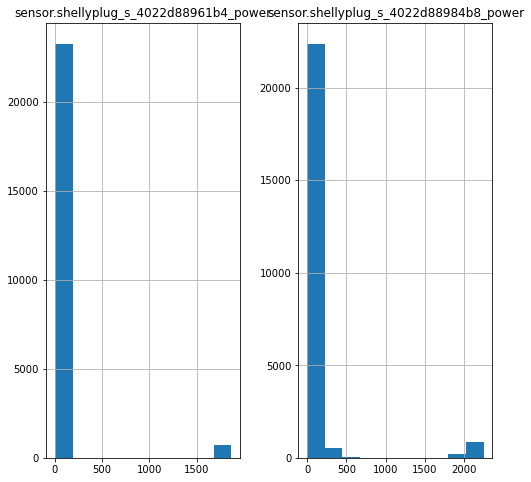

In [18]:
# Histogram
data_w.hist(bins=10, figsize=(8,8));

In [19]:
data_w.isna().any()

entity_id
last_updated                              False
sensor.shellyplug_s_4022d88961b4_power    False
sensor.shellyplug_s_4022d88984b8_power    False
dtype: bool

Skewed data, no outliers <font color = 'red'> (as I personally believe) </font>. Data has no missing values. However, as I am not sure whether this will be the case with any data I will keep truncation functions.

In [20]:
data_w.describe()

entity_id,sensor.shellyplug_s_4022d88961b4_power,sensor.shellyplug_s_4022d88984b8_power
count,24008.000000,24008.000000
mean,55.273417,156.069614
std,303.964974,425.237736
min,0.000000,0.000000
25%,0.000000,6.200000
50%,0.000000,57.600000
75%,0.000000,101.500000
max,1867.400000,2247.700000


In [21]:
data_w

entity_id,last_updated,sensor.shellyplug_s_4022d88961b4_power,sensor.shellyplug_s_4022d88984b8_power
0,2022-12-25 18:23:02.912953,0.0,0.0
1,2022-12-25 18:27:23.058601,0.0,0.0
2,2022-12-25 18:27:23.351347,0.0,0.0
3,2022-12-25 18:30:43.965837,0.0,0.0
4,2022-12-25 18:30:44.209707,0.0,0.0
...,...,...,...
24003,2023-01-09 10:52:37.625289,0.0,6.1
24004,2023-01-09 10:52:52.645557,0.0,6.0
24005,2023-01-09 10:53:07.643947,0.0,6.1
24006,2023-01-09 10:53:22.644619,0.0,6.0


In [22]:
def outlier_truncation(self, series, factor=1.5, verbose=0):
    from tqdm import tqdm
    
    q1 = series.quantile(0.25)
    q3 = series.quantile(0.75)
    iqr = q3-q1
    
    lower_bound = q1 - factor*iqr
    upper_bound = q3 + factor*iqr
    
    output = []
    counter = 0
    for item in (tqdm(series, desc=f'[outlier truncation: {series.name}]') if verbose != 0 else series):
        if item > upper_bound:
            output.append(int(upper_bound))
            counter += 1
        elif item < lower_bound:
            output.append(int(lower_bound))
            counter += 1
        else:
            output.append(item)
    print(f'[outlier truncation: {series.name}]: {counter} outliers were truncated.') if verbose != 0 else None 
    return output

# add the function to the class and delete global function
setattr(Preparation_Agent, 'outlier_truncation', outlier_truncation)
del outlier_truncation

In [23]:
new_df = pd.DataFrame()
new_df['573 truncated'] = prep.outlier_truncation(data_w["sensor.shellyplug_s_4022d88984b8_power"], verbose = 1)
new_df.describe()

[outlier truncation: sensor.shellyplug_s_4022d88984b8_power]: 100%|█████████| 24008/24008 [00:00<00:00, 1600623.90it/s]

[outlier truncation: sensor.shellyplug_s_4022d88984b8_power]: 1467 outliers were truncated.


,573 truncated
count,24008.000000
mean,70.977445
std,72.133720
min,0.000000
25%,6.200000
50%,57.600000
75%,101.500000
max,244.400000


In [24]:
# truncating multiple features
def truncate(self, df, features='all', factor=1.5, verbose=0):
    import time
    output = df.copy()
    features = df.select_dtypes(include=['int', 'float']).columns if features == 'all' else features

    for feature in features:
        time.sleep(0.2) if verbose != 0 else None
        row_nn = df[feature] != 0                                                                  # truncate only the values for which the device uses energy
        output.loc[row_nn, feature] = self.outlier_truncation(df.loc[row_nn, feature], factor=factor, verbose=verbose) # Truncatation factor = 1.5 * IQR
        print('\n') if verbose != 0 else None
    return output

# add to class
setattr(Preparation_Agent, 'truncate', truncate)
del truncate

In [25]:
household_t = prep.truncate(data_w, verbose = 1)
household_t.describe().round(2)

[outlier truncation: sensor.shellyplug_s_4022d88961b4_power]: 100%|███████████| 4759/4759 [00:00<00:00, 1576051.54it/s]


[outlier truncation: sensor.shellyplug_s_4022d88961b4_power]: 725 outliers were truncated.




[outlier truncation: sensor.shellyplug_s_4022d88984b8_power]: 100%|█████████| 18894/18894 [00:00<00:00, 1571740.97it/s]

[outlier truncation: sensor.shellyplug_s_4022d88984b8_power]: 1402 outliers were truncated.




entity_id,sensor.shellyplug_s_4022d88961b4_power,sensor.shellyplug_s_4022d88984b8_power
count,24008.00,24008.00
mean,5.19,72.05
std,19.76,74.79
min,0.00,0.00
25%,0.00,6.20
50%,0.00,57.60
75%,0.00,101.50
max,105.00,262.30


### MinMax Scaling

In [26]:
def scale(self, df, features='all', kind='MinMax', verbose=0):
    output = df.copy()
    features = df.select_dtypes(include=['int', 'float']).columns if features == 'all' else features
    
    if kind == 'MinMax':
        from sklearn.preprocessing import MinMaxScaler
        
        scaler = MinMaxScaler()
        output[features] = scaler.fit_transform(df[features])
        print('[MinMaxScaler] Finished scaling the data.') if verbose != 0 else None
    else:
        raise InputError('Chosen scaling method is not available.')
    return output 

# add to the class
setattr(Preparation_Agent, 'scale', scale)
del scale

In [27]:
household_s = prep.scale(household_t, verbose = 0)

In [28]:
household_s

entity_id,last_updated,sensor.shellyplug_s_4022d88961b4_power,sensor.shellyplug_s_4022d88984b8_power
0,2022-12-25 18:23:02.912953,0.0,0.000000
1,2022-12-25 18:27:23.058601,0.0,0.000000
2,2022-12-25 18:27:23.351347,0.0,0.000000
3,2022-12-25 18:30:43.965837,0.0,0.000000
4,2022-12-25 18:30:44.209707,0.0,0.000000
...,...,...,...
24003,2023-01-09 10:52:37.625289,0.0,0.023256
24004,2023-01-09 10:52:52.645557,0.0,0.022875
24005,2023-01-09 10:53:07.643947,0.0,0.023256
24006,2023-01-09 10:53:22.644619,0.0,0.022875


### Feature Creation

**Resampling by hour**
First, I will create the function that aggregates the dataframe for the period X, it can be 60 minutes, it can be one day. It is resampled this way, that we receive sum of the variables per hour/day and not the average as in initial preparation agent. <font color = 'red'> If you consider that we should take mean, please let me know. </font>


In [29]:
def get_timespan(self, df, start, timedelta_params):
    df.last_updated = pd.to_datetime(df.last_updated)
    df = df.set_index('last_updated')
    start = pd.to_datetime(start) if type(start) != type(pd.to_datetime('1970-01-01')) else start 
    end = start + pd.Timedelta(**timedelta_params)
    return df[start:end].reset_index()

# add to the helper class
setattr(Helper, 'get_timespan', get_timespan)
del get_timespan

In [30]:
# Extracting data for one day
helper = Helper()
from datetime import datetime

timedelta_params = {'days': 1, 'seconds': -1}   # returns data for just one day
day = helper.get_timespan(data_w, "2023-01-01", timedelta_params)
day

entity_id,last_updated,sensor.shellyplug_s_4022d88961b4_power,sensor.shellyplug_s_4022d88984b8_power
0,2023-01-01 13:07:18.115780,0.0,4.2
1,2023-01-01 13:07:19.115524,0.0,6.6
2,2023-01-01 13:07:21.115390,0.0,26.4
3,2023-01-01 13:07:22.117359,0.0,23.7
4,2023-01-01 13:07:25.113946,0.0,0.0
...,...,...,...
5103,2023-01-01 19:01:04.601191,0.0,5.9
5104,2023-01-01 19:01:19.601703,0.0,6.0
5105,2023-01-01 19:01:27.490391,0.0,0.0
5106,2023-01-01 20:51:01.931823,0.0,0.0


In [31]:
#aggregating per hour
data = day.resample('60T', on = 'last_updated').mean()
data.describe().round(3)


entity_id,sensor.shellyplug_s_4022d88961b4_power,sensor.shellyplug_s_4022d88984b8_power
count,8.0,8.000
mean,0.0,310.691
std,0.0,494.521
min,0.0,0.000
25%,0.0,61.676
50%,0.0,88.959
75%,0.0,262.063
max,0.0,1381.232


In [32]:
data

entity_id,sensor.shellyplug_s_4022d88961b4_power,sensor.shellyplug_s_4022d88984b8_power
last_updated,,
2023-01-01 13:00:00,0.0,736.927223
2023-01-01 14:00:00,0.0,81.303515
2023-01-01 15:00:00,0.0,80.515755
2023-01-01 16:00:00,0.0,103.774550
2023-01-01 17:00:00,0.0,1381.232203
2023-01-01 18:00:00,0.0,96.614206
2023-01-01 19:00:00,0.0,5.157143
2023-01-01 20:00:00,0.0,0.000000


<font color = 'red'> Mean gives back NaN if there are only 0! So we have to replace all nan values with 0. Otherwise later on the load agent does not find right load patterns.</font>.

In [33]:
output = data_w.copy()
output.last_updated

0       2022-12-25 18:23:02.912953
1       2022-12-25 18:27:23.058601
2       2022-12-25 18:27:23.351347
3       2022-12-25 18:30:43.965837
4       2022-12-25 18:30:44.209707
                   ...            
24003   2023-01-09 10:52:37.625289
24004   2023-01-09 10:52:52.645557
24005   2023-01-09 10:53:07.643947
24006   2023-01-09 10:53:22.644619
24007   2023-01-09 10:53:27.504121
Name: last_updated, Length: 24008, dtype: datetime64[ns]

In [34]:
output['last_updated'] = pd.to_datetime(output['last_updated'])
output

entity_id,last_updated,sensor.shellyplug_s_4022d88961b4_power,sensor.shellyplug_s_4022d88984b8_power
0,2022-12-25 18:23:02.912953,0.0,0.0
1,2022-12-25 18:27:23.058601,0.0,0.0
2,2022-12-25 18:27:23.351347,0.0,0.0
3,2022-12-25 18:30:43.965837,0.0,0.0
4,2022-12-25 18:30:44.209707,0.0,0.0
...,...,...,...
24003,2023-01-09 10:52:37.625289,0.0,6.1
24004,2023-01-09 10:52:52.645557,0.0,6.0
24005,2023-01-09 10:53:07.643947,0.0,6.1
24006,2023-01-09 10:53:22.644619,0.0,6.0


In [35]:
output.last_updated

0       2022-12-25 18:23:02.912953
1       2022-12-25 18:27:23.058601
2       2022-12-25 18:27:23.351347
3       2022-12-25 18:30:43.965837
4       2022-12-25 18:30:44.209707
                   ...            
24003   2023-01-09 10:52:37.625289
24004   2023-01-09 10:52:52.645557
24005   2023-01-09 10:53:07.643947
24006   2023-01-09 10:53:22.644619
24007   2023-01-09 10:53:27.504121
Name: last_updated, Length: 24008, dtype: datetime64[ns]

In [36]:
output = output.resample('60T', on="last_updated").mean()
output

entity_id,sensor.shellyplug_s_4022d88961b4_power,sensor.shellyplug_s_4022d88984b8_power
last_updated,,
2022-12-25 18:00:00,0.248276,0.198276
2022-12-25 19:00:00,NaN,NaN
2022-12-25 20:00:00,NaN,NaN
2022-12-25 21:00:00,NaN,NaN
2022-12-25 22:00:00,NaN,NaN
...,...,...
2023-01-09 06:00:00,NaN,NaN
2023-01-09 07:00:00,NaN,NaN
2023-01-09 08:00:00,0.000000,0.000000


In [37]:
output = output.replace(np.nan, 0)
output

entity_id,sensor.shellyplug_s_4022d88961b4_power,sensor.shellyplug_s_4022d88984b8_power
last_updated,,
2022-12-25 18:00:00,0.248276,0.198276
2022-12-25 19:00:00,0.000000,0.000000
2022-12-25 20:00:00,0.000000,0.000000
2022-12-25 21:00:00,0.000000,0.000000
2022-12-25 22:00:00,0.000000,0.000000
...,...,...
2023-01-09 06:00:00,0.000000,0.000000
2023-01-09 07:00:00,0.000000,0.000000
2023-01-09 08:00:00,0.000000,0.000000


<font color = 'red'> In Zharova's approach there is function aggregate, I changed it to resampling. Note, she takes **mean**, I take sum as hourly total consumption </font>.

In [38]:
#def aggregate(self, df, resample_param):
#    return df.resample(resample_param).mean().copy()

In [39]:
# add to helper and not to preparation agent
def aggregate(self, df, period = '60T'):
    output = df.copy()
    output['last_updated'] = pd.to_datetime(output['last_updated'])
    output = output.resample(period, on="last_updated").mean()
    output = output.replace(np.nan, 0)
    return output

setattr(Preparation_Agent, 'aggregate', aggregate)
del aggregate

In [40]:
data_w

entity_id,last_updated,sensor.shellyplug_s_4022d88961b4_power,sensor.shellyplug_s_4022d88984b8_power
0,2022-12-25 18:23:02.912953,0.0,0.0
1,2022-12-25 18:27:23.058601,0.0,0.0
2,2022-12-25 18:27:23.351347,0.0,0.0
3,2022-12-25 18:30:43.965837,0.0,0.0
4,2022-12-25 18:30:44.209707,0.0,0.0
...,...,...,...
24003,2023-01-09 10:52:37.625289,0.0,6.1
24004,2023-01-09 10:52:52.645557,0.0,6.0
24005,2023-01-09 10:53:07.643947,0.0,6.1
24006,2023-01-09 10:53:22.644619,0.0,6.0


In [41]:
data = prep.aggregate(data_w)
data

entity_id,sensor.shellyplug_s_4022d88961b4_power,sensor.shellyplug_s_4022d88984b8_power
last_updated,,
2022-12-25 18:00:00,0.248276,0.198276
2022-12-25 19:00:00,0.000000,0.000000
2022-12-25 20:00:00,0.000000,0.000000
2022-12-25 21:00:00,0.000000,0.000000
2022-12-25 22:00:00,0.000000,0.000000
...,...,...
2023-01-09 06:00:00,0.000000,0.000000
2023-01-09 07:00:00,0.000000,0.000000
2023-01-09 08:00:00,0.000000,0.000000


In [42]:
def plot_consumption(self, df, features='all', figsize='default', threshold=None, title='Consumption'):
    import matplotlib.pyplot as plt

    df = df.copy()
    features = [column for column in df.columns if column not in ['Unix', 'Issues']] if features == 'all' else features

    fig, ax = plt.subplots(figsize=figsize) if figsize != 'default' else plt.subplots()
    if threshold != None:
        df['threshold'] = [threshold]*df.shape[0]
        ax.plot(df['threshold'], color = 'tab:red')
    for feature in features:
        ax.plot(df[feature])
    ax.legend(['threshold'] + features) if threshold != None else ax.legend(features)
    ax.set_title(title);

# add to the class
setattr(Preparation_Agent, 'plot_consumption', plot_consumption)
del plot_consumption


<font color='red'> **How do we define the threshold in our case?** </font> I randomly took threshold in this case.


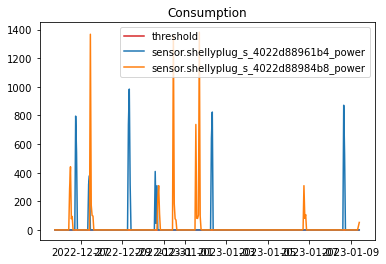

In [43]:
prep.plot_consumption(data, threshold = 1)

**Device Usage Feature**

In [44]:
def get_device_usage(self, df, device, threshold):
    return (df.loc[:, device] > threshold).astype('int')

# add to class
setattr(Preparation_Agent, 'get_device_usage', get_device_usage)
del get_device_usage

In [45]:
with pd.option_context('display.max_rows', None, 'display.max_columns', None):  # more options can be specified also
    print(prep.get_device_usage(data, "sensor.shellyplug_s_4022d88984b8_power", 1))



last_updated
2022-12-25 18:00:00    0
2022-12-25 19:00:00    0
2022-12-25 20:00:00    0
2022-12-25 21:00:00    0
2022-12-25 22:00:00    0
2022-12-25 23:00:00    0
2022-12-26 00:00:00    0
2022-12-26 01:00:00    0
2022-12-26 02:00:00    0
2022-12-26 03:00:00    0
2022-12-26 04:00:00    0
2022-12-26 05:00:00    0
2022-12-26 06:00:00    0
2022-12-26 07:00:00    0
2022-12-26 08:00:00    0
2022-12-26 09:00:00    0
2022-12-26 10:00:00    0
2022-12-26 11:00:00    1
2022-12-26 12:00:00    1
2022-12-26 13:00:00    1
2022-12-26 14:00:00    1
2022-12-26 15:00:00    0
2022-12-26 16:00:00    0
2022-12-26 17:00:00    0
2022-12-26 18:00:00    0
2022-12-26 19:00:00    0
2022-12-26 20:00:00    0
2022-12-26 21:00:00    0
2022-12-26 22:00:00    0
2022-12-26 23:00:00    0
2022-12-27 00:00:00    0
2022-12-27 01:00:00    0
2022-12-27 02:00:00    0
2022-12-27 03:00:00    0
2022-12-27 04:00:00    0
2022-12-27 05:00:00    0
2022-12-27 06:00:00    0
2022-12-27 07:00:00    0
2022-12-27 08:00:00    0
2022-12-27 0

In [46]:
prep.get_device_usage(data, "sensor.shellyplug_s_4022d88961b4_power", 1)

last_updated
2022-12-25 18:00:00    0
2022-12-25 19:00:00    0
2022-12-25 20:00:00    0
2022-12-25 21:00:00    0
2022-12-25 22:00:00    0
                      ..
2023-01-09 06:00:00    0
2023-01-09 07:00:00    0
2023-01-09 08:00:00    0
2023-01-09 09:00:00    0
2023-01-09 10:00:00    0
Freq: 60T, Name: sensor.shellyplug_s_4022d88961b4_power, Length: 353, dtype: int32

Function that creates binary variable and aggregates in order to show whether variable has been or not used in particular day.

In [47]:
## daily appliance usage
data_all = prep.aggregate(household_s, '1D')
shiftable_devices = ["sensor.shellyplug_s_4022d88961b4_power", "sensor.shellyplug_s_4022d88984b8_power"]

for appliance in shiftable_devices:
    data_all['node'+ str(appliance) + '_usage'] = prep.get_device_usage(data_all, appliance, 0)
data_all.filter(regex = 'usage')

entity_id,nodesensor.shellyplug_s_4022d88961b4_power_usage,nodesensor.shellyplug_s_4022d88984b8_power_usage
last_updated,,
2022-12-25,1,1
2022-12-26,1,1
2022-12-27,1,1
2022-12-28,0,0
2022-12-29,1,0
2022-12-30,1,1
2022-12-31,0,1
2023-01-01,0,1
2023-01-02,1,0


Activity feature appear in my notebook a bit ealier than in original one.

In [48]:
def get_activity(self, df, active_appliances, threshold):
    import pandas as pd
    active = pd.DataFrame({appliance: df[appliance] > threshold for appliance in active_appliances})
    return active.apply(any, axis = 1).astype('int')

# add to the Preparation_agent class
setattr(Preparation_Agent, 'get_activity', get_activity)
del get_activity

In [49]:
shiftable_devices = ["sensor.shellyplug_s_4022d88961b4_power", "sensor.shellyplug_s_4022d88984b8_power"]

data_all['activity'] = prep.get_activity(data_all, shiftable_devices, 0)
data_all

entity_id,sensor.shellyplug_s_4022d88961b4_power,sensor.shellyplug_s_4022d88984b8_power,nodesensor.shellyplug_s_4022d88961b4_power_usage,nodesensor.shellyplug_s_4022d88984b8_power_usage,activity
last_updated,,,,,
2022-12-25,0.002365,0.000756,1,1,1
2022-12-26,0.052354,0.229174,1,1,1
2022-12-27,0.021205,0.286782,1,1,1
2022-12-28,0.000000,0.000000,0,0,0
2022-12-29,0.607497,0.000000,1,0,1
2022-12-30,0.152870,0.194022,1,1,1
2022-12-31,0.000000,0.314983,0,1,1
2023-01-01,0.000000,0.341561,0,1,1
2023-01-02,0.553594,0.000000,1,0,1


**Periods since the last device usage**

In [50]:
def get_last_usage(self, series):
    last_usage = []
    for idx in range(len(series)):
        shift = 1
        if pd.isna(series.shift(periods = 1)[idx]):
            shift = None
        else:
            while series.shift(periods = shift)[idx] == 0:
                shift += 1
        last_usage.append(shift)
    return last_usage

def get_last_usages(self, df, features):
    import pandas as pd

    output = pd.DataFrame()
    for feature in features:
        output['periods_since_last_'+str(feature)] = self.get_last_usage(df[feature])
    output.set_index(df.index, inplace=True)
    return output


setattr(Preparation_Agent, 'get_last_usage', get_last_usage)
del get_last_usage

setattr(Preparation_Agent, 'get_last_usages', get_last_usages)
del get_last_usages

In [51]:
usage_cols = data_all.filter(regex = 'usage')

data_all = data_all.join(prep.get_last_usages(data_all, usage_cols))
data_all.iloc[:, -10:]

,sensor.shellyplug_s_4022d88961b4_power,sensor.shellyplug_s_4022d88984b8_power,nodesensor.shellyplug_s_4022d88961b4_power_usage,nodesensor.shellyplug_s_4022d88984b8_power_usage,activity,periods_since_last_nodesensor.shellyplug_s_4022d88961b4_power_usage,periods_since_last_nodesensor.shellyplug_s_4022d88984b8_power_usage
last_updated,,,,,,,
2022-12-25,0.002365,0.000756,1,1,1,NaN,NaN
2022-12-26,0.052354,0.229174,1,1,1,1.0,1.0
2022-12-27,0.021205,0.286782,1,1,1,1.0,1.0
2022-12-28,0.000000,0.000000,0,0,0,1.0,1.0
2022-12-29,0.607497,0.000000,1,0,1,2.0,2.0
2022-12-30,0.152870,0.194022,1,1,1,1.0,3.0
2022-12-31,0.000000,0.314983,0,1,1,1.0,1.0
2023-01-01,0.000000,0.341561,0,1,1,2.0,1.0
2023-01-02,0.553594,0.000000,1,0,1,3.0,1.0


**Time Features Based on DatetimeIndex**

In [52]:
def get_time_feature(self, df, features='all'):
    import pandas as pd
    functions = {
        'hour': lambda df: df.index.hour, 
        'day_of_week': lambda df: df.index.dayofweek,
        'day_name': lambda df: df.index.day_name().astype('category'),
        'month': lambda df: df.index.month, 
        'month_name': lambda df: df.index.month_name().astype('category'),
        'weekend': lambda df: [int(x in ['Saturday', 'Sunday']) for x in  list(df.index.day_name())]
    }
    if features == 'all':
        output = pd.DataFrame({function[0]: function[1](df) for function in functions.items()})
    else:
        output = pd.DataFrame({function[0]: function[1](df) for function in functions.items() if function[0] in features})
    output.set_index(df.index, inplace=True)
    return output

# add to the Preparation_agent class
setattr(Preparation_Agent, 'get_time_feature', get_time_feature)
del get_time_feature

In [53]:
day

entity_id,last_updated,sensor.shellyplug_s_4022d88961b4_power,sensor.shellyplug_s_4022d88984b8_power
0,2023-01-01 13:07:18.115780,0.0,4.2
1,2023-01-01 13:07:19.115524,0.0,6.6
2,2023-01-01 13:07:21.115390,0.0,26.4
3,2023-01-01 13:07:22.117359,0.0,23.7
4,2023-01-01 13:07:25.113946,0.0,0.0
...,...,...,...
5103,2023-01-01 19:01:04.601191,0.0,5.9
5104,2023-01-01 19:01:19.601703,0.0,6.0
5105,2023-01-01 19:01:27.490391,0.0,0.0
5106,2023-01-01 20:51:01.931823,0.0,0.0


In [54]:
day = day.set_index('last_updated')
day = day.loc[:,["sensor.shellyplug_s_4022d88961b4_power", "sensor.shellyplug_s_4022d88984b8_power"]]
day = day.reset_index()
day['last_updated']=pd.to_datetime(day['last_updated'])
day = day.set_index('last_updated')
day = day.join(prep.get_time_feature(day))

In [55]:
day.head()

,sensor.shellyplug_s_4022d88961b4_power,sensor.shellyplug_s_4022d88984b8_power,hour,day_of_week,day_name,month,month_name,weekend
last_updated,,,,,,,,
2023-01-01 13:07:18.115780,0.0,4.2,13,6,Sunday,1,January,1
2023-01-01 13:07:19.115524,0.0,6.6,13,6,Sunday,1,January,1
2023-01-01 13:07:21.115390,0.0,26.4,13,6,Sunday,1,January,1
2023-01-01 13:07:22.117359,0.0,23.7,13,6,Sunday,1,January,1
2023-01-01 13:07:25.113946,0.0,0.0,13,6,Sunday,1,January,1


**Time Lag Features**

In [56]:
def get_time_lags(self, df, features, lags):
    import pandas as pd

    output = pd.DataFrame()
    for feature in features:
        for lag in lags:
            output[f'{feature}_lag_{lag}'] = df[feature].shift(periods=lag)
    return output

# add to the Preparation_agent class
setattr(Preparation_Agent, 'get_time_lags', get_time_lags)
del get_time_lags

In [57]:
day['activity'] = prep.get_activity(day, shiftable_devices, 1)

In [58]:
day

,sensor.shellyplug_s_4022d88961b4_power,sensor.shellyplug_s_4022d88984b8_power,hour,day_of_week,day_name,month,month_name,weekend,activity
last_updated,,,,,,,,,
2023-01-01 13:07:18.115780,0.0,4.2,13,6,Sunday,1,January,1,1
2023-01-01 13:07:19.115524,0.0,6.6,13,6,Sunday,1,January,1,1
2023-01-01 13:07:21.115390,0.0,26.4,13,6,Sunday,1,January,1,1
2023-01-01 13:07:22.117359,0.0,23.7,13,6,Sunday,1,January,1,1
2023-01-01 13:07:25.113946,0.0,0.0,13,6,Sunday,1,January,1,0
...,...,...,...,...,...,...,...,...,...
2023-01-01 19:01:04.601191,0.0,5.9,19,6,Sunday,1,January,1,1
2023-01-01 19:01:19.601703,0.0,6.0,19,6,Sunday,1,January,1,1
2023-01-01 19:01:27.490391,0.0,0.0,19,6,Sunday,1,January,1,0


In [59]:
day = day.join(prep.get_time_lags(day, ['hour','activity'], [1, 2, 5]))
day.iloc[:, -6:]

,hour_lag_1,hour_lag_2,hour_lag_5,activity_lag_1,activity_lag_2,activity_lag_5
last_updated,,,,,,
2023-01-01 13:07:18.115780,NaN,NaN,NaN,NaN,NaN,NaN
2023-01-01 13:07:19.115524,13.0,NaN,NaN,1.0,NaN,NaN
2023-01-01 13:07:21.115390,13.0,13.0,NaN,1.0,1.0,NaN
2023-01-01 13:07:22.117359,13.0,13.0,NaN,1.0,1.0,NaN
2023-01-01 13:07:25.113946,13.0,13.0,NaN,1.0,1.0,NaN
...,...,...,...,...,...,...
2023-01-01 19:01:04.601191,19.0,19.0,18.0,1.0,1.0,1.0
2023-01-01 19:01:19.601703,19.0,19.0,19.0,1.0,1.0,1.0
2023-01-01 19:01:27.490391,19.0,19.0,19.0,1.0,1.0,1.0


### Defining optimal threshold


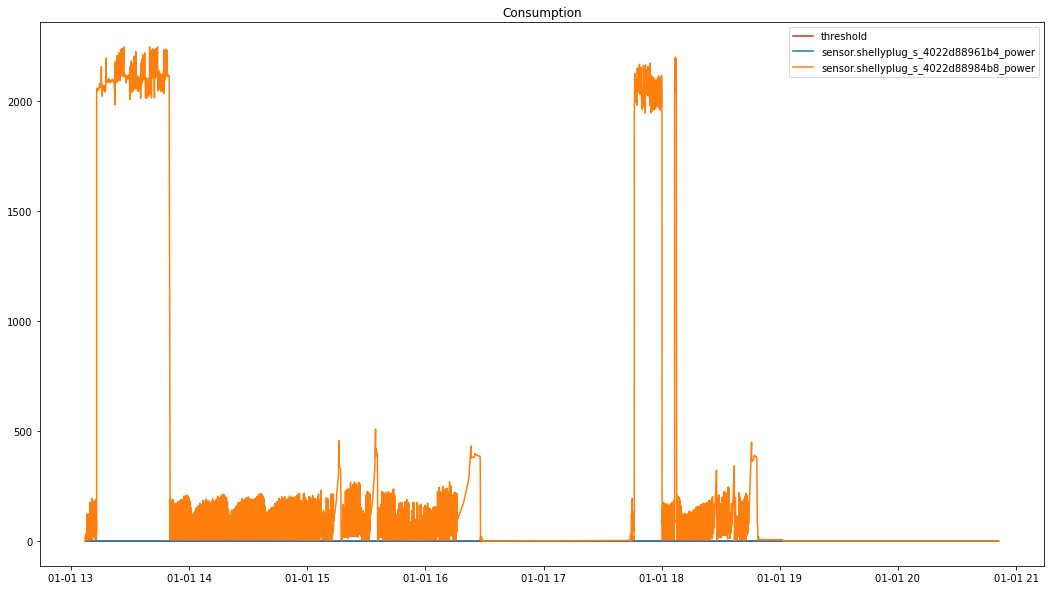

In [60]:
helper.plot_consumption(day, shiftable_devices, figsize=(18,10), threshold=.15)

In [61]:
def visualize_threshold(self, df, threshold, appliances, figsize=(18,5)):
    # data prep
    for appliance in appliances:
        df[str(appliance) + '_usage'] = self.get_device_usage(df, appliance, threshold)
    df = df.join(self.get_time_feature(df))
    df['activity'] = self.get_activity(df, appliances, threshold)

    # plotting 
    import matplotlib.pyplot as plt

    usage_cols = [column for column in df.columns if str(column).endswith('_usage')]
    columns = ['activity'] + usage_cols

    fig, axes = plt.subplots(1,3, figsize=figsize)

    # hour
    hour = df.groupby('hour').mean()[columns]
    hour.plot(ax=axes[0])
    axes[0].set_ylim(-.1, 1.1);
    axes[0].set_title(f'[threshold: {round(threshold, 4)}] Activity ratio per hour')

    # week 
    usage_cols = [column for column in df.columns if str(column).endswith('_usage')]
    week = df.groupby('day_name').mean()[columns]
    week = week.reindex(['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday'])
    week.plot(ax=axes[1])
    axes[1].set_ylim(-.1, 1.1);
    #axes[1].set_xticklabels(['']+list(week.index), rotation=90)
    axes[1].set_title(f'[threshold: {round(threshold, 4)}] Activity ratio per day of the week')

    # month
    usage_cols = [column for column in df.columns if str(column).endswith('_usage')]
    month = df.groupby('month').mean()[columns]
    month.plot(ax=axes[2])
    axes[2].set_ylim(-.1, 1.1);
    axes[2].set_title(f'[threshold: {round(threshold, 4)}] Activity ratio per month')

# add to the Preparation_agent class
setattr(Preparation_Agent, 'visualize_threshold', visualize_threshold)
del visualize_threshold

In [62]:
def validate_thresholds(self, df, thresholds, appliances, figsize=(18,5)):
    import time
    from tqdm import tqdm
    for threshold in tqdm(thresholds):
        self.visualize_threshold(df, threshold, appliances, figsize)
    time.sleep(0.2)
    print('\n')

# add to the Preparation_agent class
setattr(Preparation_Agent, 'validate_thresholds', validate_thresholds)
del validate_thresholds

In [63]:
household_s = household_s.set_index('last_updated')
df = helper.aggregate(household_s, '7T')
thresholds = [0] + list(np.geomspace(.1, .5, 5))

prep.validate_thresholds(df, thresholds, shiftable_devices)

TypeError: Only valid with DatetimeIndex, TimedeltaIndex or PeriodIndex, but got an instance of 'Index'

In [65]:
thresholds

NameError: name 'thresholds' is not defined

In [66]:
threshold = .15

prep.visualize_threshold(df, threshold, shiftable_devices)

NameError: name 'df' is not defined

### Activity Pipeline


In [67]:
truncation_params = {
    'features': 'all', 
    'factor': 1.5, 
    'verbose': 1
}

scale_params = {
    'features': 'all', 
    'kind': 'MinMax', 
    'verbose': 1
}

aggregate_params = {
    'resample_param': '60T'
}
#update with active appliances attributes_ids
activity_params = {
    'active_appliances': shiftable_devices,
    'threshold': .15
}

time_params = {
    'features': ['hour', 'day_name']
}

activity_lag_params = {
    'features': ['activity'],
    'lags': [24, 48, 72]
}

activity_pipe_params = {
    'truncate': truncation_params,
    'scale': scale_params,
    'aggregate': aggregate_params,
    'activity': activity_params,
    'time': time_params,
    'activity_lag': activity_lag_params
}

In [68]:
def pipeline_activity(self, df, params):
    from helper_functions import Helper
    
    import pandas as pd
    helper = Helper()
    df = df.copy()
    output = pd.DataFrame()

    df  = self.unpacking_attributes(prep.input)
    df = self.access_shiftable_devices(df)
    # Data cleaning
    df = self.truncate(df, **params['truncate'],)
    df = self.scale(df, **params['scale'])

    df['last_updated'] = pd.to_datetime(df['last_updated'])
    df = df.set_index('last_updated')
    # Aggregate to hour level
    df = helper.aggregate(df, **params['aggregate'])

    # Activity feature
    output['activity'] = self.get_activity(df, **params['activity'])
    
    ## Time feature
    output = output.join(self.get_time_feature(df, **params['time']))

    # Activity lags
    output = output.join(self.get_time_lags(output, **params['activity_lag']))

    # Dummy coding
    output = pd.get_dummies(output, drop_first=True)

    return output

# add to the Preparation_agent class
setattr(Preparation_Agent, 'pipeline_activity', pipeline_activity)
del pipeline_activity

In [69]:
prep = Preparation_Agent(dbfile, shiftable_devices)

In [70]:
prep.pipeline_activity(prep.input, activity_pipe_params)

[outlier truncation: sensor.shellyplug_s_4022d88961b4_power]: 100%|███████████| 4759/4759 [00:00<00:00, 1594686.65it/s]


[outlier truncation: sensor.shellyplug_s_4022d88961b4_power]: 725 outliers were truncated.




[outlier truncation: sensor.shellyplug_s_4022d88984b8_power]: 100%|█████████| 18894/18894 [00:00<00:00, 2940417.04it/s]

[outlier truncation: sensor.shellyplug_s_4022d88984b8_power]: 1402 outliers were truncated.


[MinMaxScaler] Finished scaling the data.


,activity,hour,activity_lag_24,activity_lag_48,activity_lag_72,day_name_Monday,day_name_Saturday,day_name_Sunday,day_name_Thursday,day_name_Tuesday,day_name_Wednesday
last_updated,,,,,,,,,,,
2022-12-25 18:00:00,0,18,NaN,NaN,NaN,0,0,1,0,0,0
2022-12-25 19:00:00,0,19,NaN,NaN,NaN,0,0,1,0,0,0
2022-12-25 20:00:00,0,20,NaN,NaN,NaN,0,0,1,0,0,0
2022-12-25 21:00:00,0,21,NaN,NaN,NaN,0,0,1,0,0,0
2022-12-25 22:00:00,0,22,NaN,NaN,NaN,0,0,1,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...
2023-01-09 06:00:00,0,6,0.0,0.0,0.0,1,0,0,0,0,0
2023-01-09 07:00:00,0,7,0.0,0.0,0.0,1,0,0,0,0,0
2023-01-09 08:00:00,0,8,0.0,0.0,0.0,1,0,0,0,0,0


### Load Pipeline

The load agent requires cleaned energy consumption data for the shiftable devices. Therefore, we calculate the device usage for these appliances based on the truncated and scaled data and return the energy consumption of the shiftable devices only if we detected a device usage. The data for the load agent will be aggregated to the hour level.


In [71]:
truncation_params = {
    'features': 'all', 
    'factor': 1.5, 
    'verbose': 1
}

scale_params = {
    'features': 'all', 
    'kind': 'MinMax', 
    'verbose': 1
}

aggregate_params = {
    'resample_param': '60T'
}

shiftable_devices = ["sensor.shellyplug_s_4022d88961b4_power", "sensor.shellyplug_s_4022d88984b8_power"]

device_params = {
    'threshold': 0.15
}

load_pipe_params = {
    'truncate': truncation_params,
    'scale': scale_params,
    'aggregate': aggregate_params,
    'shiftable_devices': shiftable_devices, 
    'device': device_params
}

In [72]:
def pipeline_load(self, df, params):
    from helper_functions import Helper
    import pandas as pd

    helper = Helper()
    
    df  = self.unpacking_attributes(prep.input)
    df = self.access_shiftable_devices(df)
    
    df = df.copy()
    output = pd.DataFrame()

    # Data cleaning
    # df = self.truncate(df, **params['truncate'],)
    scaled = self.scale(df, **params['scale'])

    df['last_updated'] = pd.to_datetime(df['last_updated'])
    df = df.set_index('last_updated')

    scaled['last_updated'] = pd.to_datetime(scaled['last_updated'])
    scaled = scaled.set_index('last_updated')

    # aggregate
    df = helper.aggregate_load(df, **params['aggregate'])
    scaled = helper.aggregate_load(scaled, **params['aggregate'])

    # Get device usage and transform to energy consumption
    for device in params['shiftable_devices']:
        df[str(device) + '_usage'] = self.get_device_usage(df, device, **params['device'])
        output[device] = df.apply(lambda timestamp: timestamp[device] * timestamp[str(device) + '_usage'], axis = 1)

    return output, scaled, df

# add to the Preparation_agent class
setattr(Preparation_Agent, 'pipeline_load', pipeline_load)
del pipeline_load

In [73]:
output, scaled, df = prep.pipeline_load(prep.input, load_pipe_params)
df

[MinMaxScaler] Finished scaling the data.


entity_id,sensor.shellyplug_s_4022d88961b4_power,sensor.shellyplug_s_4022d88984b8_power,sensor.shellyplug_s_4022d88961b4_power_usage,sensor.shellyplug_s_4022d88984b8_power_usage
last_updated,,,,
2022-12-25 18:00:00,0.248276,0.198276,1,1
2022-12-25 19:00:00,0.000000,0.000000,0,0
2022-12-25 20:00:00,0.000000,0.000000,0,0
2022-12-25 21:00:00,0.000000,0.000000,0,0
2022-12-25 22:00:00,0.000000,0.000000,0,0
...,...,...,...,...
2023-01-09 06:00:00,0.000000,0.000000,0,0
2023-01-09 07:00:00,0.000000,0.000000,0,0
2023-01-09 08:00:00,0.000000,0.000000,0,0


In [74]:
with pd.option_context('display.max_rows', None, 'display.max_columns', None):  # more options can be specified also
    print(df['sensor.shellyplug_s_4022d88984b8_power'])

last_updated
2022-12-25 18:00:00       0.198276
2022-12-25 19:00:00       0.000000
2022-12-25 20:00:00       0.000000
2022-12-25 21:00:00       0.000000
2022-12-25 22:00:00       0.000000
2022-12-25 23:00:00       0.000000
2022-12-26 00:00:00       0.000000
2022-12-26 01:00:00       0.000000
2022-12-26 02:00:00       0.000000
2022-12-26 03:00:00       0.000000
2022-12-26 04:00:00       0.000000
2022-12-26 05:00:00       0.000000
2022-12-26 06:00:00       0.000000
2022-12-26 07:00:00       0.000000
2022-12-26 08:00:00       0.000000
2022-12-26 09:00:00       0.000000
2022-12-26 10:00:00       0.000000
2022-12-26 11:00:00     288.104918
2022-12-26 12:00:00     441.213672
2022-12-26 13:00:00      78.097281
2022-12-26 14:00:00      94.110562
2022-12-26 15:00:00       0.000000
2022-12-26 16:00:00       0.000000
2022-12-26 17:00:00       0.000000
2022-12-26 18:00:00       0.000000
2022-12-26 19:00:00       0.000000
2022-12-26 20:00:00       0.000000
2022-12-26 21:00:00       0.000000
2022-12

In [75]:
with pd.option_context('display.max_rows', None, 'display.max_columns', None):  # more options can be specified also
    print(output['sensor.shellyplug_s_4022d88984b8_power'])

last_updated
2022-12-25 18:00:00       0.198276
2022-12-25 19:00:00       0.000000
2022-12-25 20:00:00       0.000000
2022-12-25 21:00:00       0.000000
2022-12-25 22:00:00       0.000000
2022-12-25 23:00:00       0.000000
2022-12-26 00:00:00       0.000000
2022-12-26 01:00:00       0.000000
2022-12-26 02:00:00       0.000000
2022-12-26 03:00:00       0.000000
2022-12-26 04:00:00       0.000000
2022-12-26 05:00:00       0.000000
2022-12-26 06:00:00       0.000000
2022-12-26 07:00:00       0.000000
2022-12-26 08:00:00       0.000000
2022-12-26 09:00:00       0.000000
2022-12-26 10:00:00       0.000000
2022-12-26 11:00:00     288.104918
2022-12-26 12:00:00     441.213672
2022-12-26 13:00:00      78.097281
2022-12-26 14:00:00      94.110562
2022-12-26 15:00:00       0.000000
2022-12-26 16:00:00       0.000000
2022-12-26 17:00:00       0.000000
2022-12-26 18:00:00       0.000000
2022-12-26 19:00:00       0.000000
2022-12-26 20:00:00       0.000000
2022-12-26 21:00:00       0.000000
2022-12


<font color = "red"> Here, what should I do with NAs? </font>

### Usage Pipeline

We will use the same functionality from the activity pipeline to create the activity feature for the usage agent. Furthermore, we create the device usage features for the appliances for which we will provide recommendations. As appliances for which we will provide recommendations, we used appliances that require user interaction and are time-shiftable, i.e. not bound to any specific time during the day (e.g. Television, Computer, etc.). These appliances will be called “shiftable devices”. Additionally, we create the periods since last usage feature for the shiftable devices, create time lags for activity and the shiftable devices, add further time features and aggregate the data to the day level. 


In [76]:
truncation_params = {
    'features': 'all', 
    'factor': 1.5, 
    'verbose': 1
}

scale_params = {
    'features': 'all', 
    'kind': 'MinMax', 
    'verbose': 1
}

aggregate_hour_params = {
    'resample_param': '60T'
}

activity_params = {
    'active_appliances': shiftable_devices,
    'threshold': .1
}

shiftable_devices = ["sensor.shellyplug_s_4022d88961b4_power", "sensor.shellyplug_s_4022d88984b8_power"]

device_params = {
    'threshold': 0.15
}

aggregate_day_params = {
    'resample_param': '1D'
}

time_params = {
    'features': ['day_name', 'weekend']
}

usage_pipe_params = {
    'truncate': truncation_params,
    'scale': scale_params,
    'aggregate_hour': aggregate_hour_params,
    'activity': activity_params,
    'aggregate_day': aggregate_day_params,
    'shiftable_devices': shiftable_devices, 
    'device': device_params,
    'time': time_params
}

In [77]:
def pipeline_usage(self, df, params):
    from helper_functions import Helper
    import pandas as pd

    
    helper = Helper()

    df  = self.unpacking_attributes(prep.input)
    df = self.access_shiftable_devices(df)
    
    df = df.copy()
    output = pd.DataFrame()

    # Data cleaning
    df = self.truncate(df, **params['truncate'],)
    scaled = self.scale(df, **params['scale'])
    
    #df['last_updated'] = pd.to_datetime(df['last_updated'])
    #df = df.set_index('last_updated')
    scaled['last_updated'] = pd.to_datetime(scaled['last_updated'])
    scaled = scaled.set_index('last_updated')
    
    # Aggregate to hour level
    scaled = helper.aggregate(scaled, **params['aggregate_hour'])

    # Activity feature
    output['activity'] = self.get_activity(scaled, **params['activity'])

    # Get device usage and transform to energy consumption
    for device in params['shiftable_devices']:
        output[str(device) + '_usage'] = self.get_device_usage(scaled, device, **params['device'])

    # aggregate and convert from mean to binary
    output = helper.aggregate(output, **params['aggregate_day'])
    output = output.apply(lambda x: (x > 0).astype('int'))

    # Last usage
    output = output.join(self.get_last_usages(output, output.columns))
    
    # Time features
    output = output.join(self.get_time_feature(output, **params['time']))

    # lags
    output = output.join(self.get_time_lags(output, ['activity'] + [str(device)+'_usage' for device in params['shiftable_devices']], [1,2,3]))
    output['active_last_2_days'] = ((output.activity_lag_1 == 1) | (output.activity_lag_2 == 1)).astype('int')

    # dummy coding
    output = pd.get_dummies(output, drop_first=True)
    return output

# add to the Preparation_agent class
setattr(Preparation_Agent, 'pipeline_usage', pipeline_usage)
del pipeline_usage

In [78]:
output = prep.pipeline_usage(prep.input, usage_pipe_params)

[outlier truncation: sensor.shellyplug_s_4022d88961b4_power]: 100%|████████████████████████| 4759/4759 [00:00<?, ?it/s]


[outlier truncation: sensor.shellyplug_s_4022d88961b4_power]: 725 outliers were truncated.




[outlier truncation: sensor.shellyplug_s_4022d88984b8_power]: 100%|█████████| 18894/18894 [00:00<00:00, 2720466.18it/s]

[outlier truncation: sensor.shellyplug_s_4022d88984b8_power]: 1402 outliers were truncated.


[MinMaxScaler] Finished scaling the data.


In [79]:
output

,activity,sensor.shellyplug_s_4022d88961b4_power_usage,sensor.shellyplug_s_4022d88984b8_power_usage,periods_since_last_activity,periods_since_last_sensor.shellyplug_s_4022d88961b4_power_usage,periods_since_last_sensor.shellyplug_s_4022d88984b8_power_usage,weekend,activity_lag_1,activity_lag_2,activity_lag_3,...,sensor.shellyplug_s_4022d88984b8_power_usage_lag_1,sensor.shellyplug_s_4022d88984b8_power_usage_lag_2,sensor.shellyplug_s_4022d88984b8_power_usage_lag_3,active_last_2_days,day_name_Monday,day_name_Saturday,day_name_Sunday,day_name_Thursday,day_name_Tuesday,day_name_Wednesday
last_updated,,,,,,,,,,,,,,,,,,,,,
2022-12-25,0,0,0,NaN,NaN,NaN,1,NaN,NaN,NaN,...,NaN,NaN,NaN,0,0,0,1,0,0,0
2022-12-26,1,1,1,2.0,2.0,2.0,0,0.0,NaN,NaN,...,0.0,NaN,NaN,0,1,0,0,0,0,0
2022-12-27,1,1,1,1.0,1.0,1.0,0,1.0,0.0,NaN,...,1.0,0.0,NaN,1,0,0,0,0,1,0
2022-12-28,0,0,0,1.0,1.0,1.0,0,1.0,1.0,0.0,...,1.0,1.0,0.0,1,0,0,0,0,0,1
2022-12-29,1,1,0,2.0,2.0,2.0,0,0.0,1.0,1.0,...,0.0,1.0,1.0,1,0,0,0,1,0,0
2022-12-30,1,1,1,1.0,1.0,3.0,0,1.0,0.0,1.0,...,0.0,0.0,1.0,1,0,0,0,0,0,0
2022-12-31,1,0,1,1.0,1.0,1.0,1,1.0,1.0,0.0,...,1.0,0.0,0.0,1,0,1,0,0,0,0
2023-01-01,1,0,1,1.0,2.0,1.0,1,1.0,1.0,1.0,...,1.0,1.0,0.0,1,0,0,1,0,0,0
2023-01-02,1,1,0,1.0,3.0,1.0,0,1.0,1.0,1.0,...,1.0,1.0,1.0,1,1,0,0,0,0,0


### Final: Complete Preparation Agent Class

In [80]:
class Preparation_Agent():
#installing dependencies
    import pandas as pd
    #uploading data and simple data wrangling
    def __init__(self, df, shiftable_devices):
        self.input = df
        self.shiftable_devices = shiftable_devices

    def unpacking_attributes(self, df):
        import pandas as pd
        output = df.copy()
        output['shared_attributes']=output['shared_attributes'].apply(lambda x: x.replace('true','True'))
        output['shared_attributes']=output['shared_attributes'].apply(lambda x: x.replace('false','False'))
        output['shared_attributes']=output['shared_attributes'].apply(lambda x: x.replace('null','None'))

        output['shared_attributes']=output['shared_attributes'].apply(lambda dat: dict(eval(dat)))
        df2 = pd.json_normalize(output['shared_attributes'])
        result = pd.DataFrame( pd.concat([output,df2], axis = 1).drop('shared_attributes', axis = 1))
        result = result.dropna(axis = 1, thresh=int(0.95*(len(result.columns))))
        return result

    def access_shiftable_devices(self, df, attrs= 'all'):
        import pandas as pd
        trial = df.copy()
        trial.attributes_id = trial.attributes_id.dropna()
        trial.state= pd.to_numeric(trial['state'], errors='coerce').dropna()
        if attrs == 'all':
            w_data = trial[trial.unit_of_measurement.isin(['W'])]
            w_data = trial[trial.entity_id.isin(self.shiftable_devices)]
            w_data_long = w_data[['entity_id','last_updated','state']]
            w_data_wide = pd.pivot(w_data_long,  index = ['last_updated'], columns = 'entity_id', values = 'state')
        if attrs != 'all':
            w_data = trial[trial.unit_of_measurement.isin(['W']) & trial.attributes_id.isin([attrs])]
            w_data = trial[trial.entity_id.isin(self.shiftable_devices)]
            w_data_long = w_data[['entity_id','last_updated','state']]
            w_data_wide = pd.pivot(w_data_long,  index = ['last_updated'], columns = 'entity_id', values = 'state')
        result = w_data_wide.fillna(0).reset_index()
        return(result)
    
    #basic preprocessing
    # -------------------------------------------------------------------------------------------
    def outlier_truncation(self, series, factor=1.5, verbose=0):
        from tqdm import tqdm
        
        q1 = series.quantile(0.25)
        q3 = series.quantile(0.75)
        iqr = q3-q1
        
        lower_bound = q1 - factor*iqr
        upper_bound = q3 + factor*iqr
        
        output = []
        counter = 0
        for item in (tqdm(series, desc=f'[outlier truncation: {series.name}]') if verbose != 0 else series):
            if item > upper_bound:
                output.append(int(upper_bound))
                counter += 1
            elif item < lower_bound:
                output.append(int(lower_bound))
                counter += 1
            else:
                output.append(item)
        print(f'[outlier truncation: {series.name}]: {counter} outliers were truncated.') if verbose != 0 else None 
        return output


    

    def scale(self, df, features='all', kind='MinMax', verbose=0):
        output = df.copy()
        features = df.select_dtypes(include=['int', 'float']).columns if features == 'all' else features

        if kind == 'MinMax':
            from sklearn.preprocessing import MinMaxScaler
            
            scaler = MinMaxScaler()
            output[features] = scaler.fit_transform(df[features])
            print('[MinMaxScaler] Finished scaling the data.') if verbose != 0 else None
        else:
            raise InputError('Chosen scaling method is not available.')
        return output 

    def get_timespan(self, df, start, timedelta_params):
        df.last_updated = pd.to_datetime(df.last_updated)
        df = df.set_index('last_updated')
        start = pd.to_datetime(start) if type(start) != type(pd.to_datetime('1970-01-01')) else start 
        end = start + pd.Timedelta(**timedelta_params)
        return df[start:end].reset_index()
    
    def aggregate(self, df, period = '60T'):
        output = df.copy()
        output['last_updated'] = pd.to_datetime(output['last_updated'])
        output = output.resample(period, on="last_updated").mean()
        return output
    
    def truncate(self, df, features='all', factor=1.5, verbose=0):
        import time
        output = df.copy()
        features = df.select_dtypes(include=['int', 'float']).columns if features == 'all' else features

        for feature in features:
            time.sleep(0.2) if verbose != 0 else None
            row_nn = df[feature] != 0                                                                  # truncate only the values for which the device uses energy
            output.loc[row_nn, feature] = self.outlier_truncation(df.loc[row_nn, feature], factor=factor, verbose=verbose) # Truncatation factor = 1.5 * IQR
            print('\n') if verbose != 0 else None
        return output

    
    def plot_consumption(self, df, features='all', figsize='default', threshold=None, title='Consumption'):
        df = df.copy()
        features = [column for column in df.columns if column not in ['Unix', 'Issues']] if features == 'all' else features
        fig, ax = plt.subplots(figsize=figsize) if figsize != 'default' else plt.subplots()
        if threshold != None:
            df['threshold'] = [threshold]*df.shape[0]
            ax.plot(df['threshold'], color = 'tab:red')
        for feature in features:
            ax.plot(df[feature])
        ax.legend(['threshold'] + features) if threshold != None else ax.legend(features)
        ax.set_title(title);
    # feature creation
    # -------------------------------------------------------------------------------------------
    def get_device_usage(self, df, device, threshold):
        return (df.loc[:, device] > threshold).astype('int')

    def get_activity(self, df, active_appliances, threshold):
        import pandas as pd
        active = pd.DataFrame({appliance: df[appliance] > threshold for appliance in active_appliances})
        return active.apply(any, axis = 1).astype('int')

    def get_last_usage(self, series):
        import pandas as pd
        last_usage = []
        for idx in range(len(series)):
            shift = 1
            if pd.isna(series.shift(periods = 1)[idx]):
                shift = None
            else:
                while series.shift(periods = shift)[idx] == 0:
                    shift += 1
            last_usage.append(shift)
        return last_usage

    def get_last_usages(self, df, features):
        import pandas as pd

        output = pd.DataFrame()
        for feature in features:
            output['periods_since_last_'+str(feature)] = self.get_last_usage(df[feature])
        output.set_index(df.index, inplace=True)
        return output


    def get_time_feature(self, df, features='all'):
        import pandas as pd
        functions = {
            'hour': lambda df: df.index.hour, 
            'day_of_week': lambda df: df.index.dayofweek,
            'day_name': lambda df: df.index.day_name().astype('category'),
            'month': lambda df: df.index.month, 
            'month_name': lambda df: df.index.month_name().astype('category'),
            'weekend': lambda df: [int(x in ['Saturday', 'Sunday']) for x in  list(df.index.day_name())]
        }
        if features == 'all':
            output = pd.DataFrame({function[0]: function[1](df) for function in functions.items()})
        else:
            output = pd.DataFrame({function[0]: function[1](df) for function in functions.items() if function[0] in features})
        output.set_index(df.index, inplace=True)
        return output
    
    def get_time_lags(self, df, features, lags):
        import pandas as pd
        output = pd.DataFrame()
        for feature in features:
            for lag in lags:
                output[f'{feature}_lag_{lag}'] = df[feature].shift(periods=lag)
        return output

    #visualising threshold
    # ------------------------------------------------------------------------------------------- 
    def visualize_threshold(self, df, threshold, appliances, figsize=(18,5)):
        import pandas as pd
        # data prep
        for appliance in appliances:
            df[str(appliance) + '_usage'] = self.get_device_usage(df, appliance, threshold)
        df = df.join(self.get_time_feature(df))
        df['activity'] = self.get_activity(df, appliances, threshold)

        # plotting 
        import matplotlib.pyplot as plt

        usage_cols = [column for column in df.columns if str(column).endswith('_usage')]
        columns = ['activity'] + usage_cols

        fig, axes = plt.subplots(1,3, figsize=figsize)

        # hour
        hour = df.groupby('hour').mean()[columns]
        hour.plot(ax=axes[0])
        axes[0].set_ylim(-.1, 1.1);
        axes[0].set_title(f'[threshold: {round(threshold, 4)}] Activity ratio per hour')

        # week 
        usage_cols = [column for column in df.columns if str(column).endswith('_usage')]
        week = df.groupby('day_name').mean()[columns]
        week = week.reindex(['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday'])
        week.plot(ax=axes[1])
        axes[1].set_ylim(-.1, 1.1);
        #axes[1].set_xticklabels(['']+list(week.index), rotation=90)
        axes[1].set_title(f'[threshold: {round(threshold, 4)}] Activity ratio per day of the week')

        # month
        usage_cols = [column for column in df.columns if str(column).endswith('_usage')]
        month = df.groupby('month').mean()[columns]
        month.plot(ax=axes[2])
        axes[2].set_ylim(-.1, 1.1);
        axes[2].set_title(f'[threshold: {round(threshold, 4)}] Activity ratio per month')
    def validate_thresholds(self, df, thresholds, appliances, figsize=(18,5)):

        for threshold in tqdm(thresholds):
            self.visualize_threshold(df, threshold, appliances, figsize)
        time.sleep(0.2)
        print('\n')
    
    #pipelines
    # -------------------------------------------------------------------------------------------
    #pipeline load
    def pipeline_load(self, df, params):
        from helper_functions import Helper
        import pandas as pd
        helper = Helper()
        
        df  = self.unpacking_attributes(prep.input)
        df = self.access_shiftable_devices(df)
        
        df = df.copy()
        output = pd.DataFrame()

        # Data cleaning
        df = self.truncate(df, **params['truncate'],)
        scaled = self.scale(df, **params['scale'])

        df['last_updated'] = pd.to_datetime(df['last_updated'])
        df = df.set_index('last_updated')

        scaled['last_updated'] = pd.to_datetime(scaled['last_updated'])
        scaled = scaled.set_index('last_updated')

        # aggregate
        df = helper.aggregate(df, **params['aggregate'])
        scaled = helper.aggregate(scaled, **params['aggregate'])

        # Get device usage and transform to energy consumption
        for device in params['shiftable_devices']:
            df[str(device) + '_usage'] = self.get_device_usage(scaled, device, **params['device'])
            output[device] = df.apply(lambda timestamp: timestamp[device] * timestamp[str(device) + '_usage'], axis = 1)

        return output, scaled, df
    #pipeline usage
    def pipeline_usage(self, df, params):
        from helper_functions import Helper
        import pandas as pd

        helper = Helper()

        df  = self.unpacking_attributes(self.input)
        df = self.access_shiftable_devices(df)
        
        df = df.copy()
        output = pd.DataFrame()

        # Data cleaning
        df = self.truncate(df, **params['truncate'],)
        scaled = self.scale(df, **params['scale'])
        
        #df['last_updated'] = pd.to_datetime(df['last_updated'])
        #df = df.set_index('last_updated')
        scaled['last_updated'] = pd.to_datetime(scaled['last_updated'])
        scaled = scaled.set_index('last_updated')
        
        # Aggregate to hour level
        scaled = helper.aggregate(scaled, **params['aggregate_hour'])

        # Activity feature
        output['activity'] = self.get_activity(scaled, **params['activity'])

        # Get device usage and transform to energy consumption
        for device in params['shiftable_devices']:
            output[str(device) + '_usage'] = self.get_device_usage(scaled, device, **params['device'])

        # aggregate and convert from mean to binary
        output = helper.aggregate(output, **params['aggregate_day'])
        output = output.apply(lambda x: (x > 0).astype('int'))

        # Last usage
        output = output.join(self.get_last_usages(output, output.columns))
        
        # Time features
        output = output.join(self.get_time_feature(output, **params['time']))

        # lags
        output = output.join(self.get_time_lags(output, ['activity'] + [str(device)+'_usage' for device in params['shiftable_devices']], [1,2,3]))
        output['active_last_2_days'] = ((output.activity_lag_1 == 1) | (output.activity_lag_2 == 1)).astype('int')

        # dummy coding
        output = pd.get_dummies(output, drop_first=True)
        return output

    #pipeline activity
    def pipeline_activity(self, df, params):
        from helper_functions import Helper
        import pandas as pd
        helper = Helper()
        df = df.copy()
        import pandas as pd
        output = pd.DataFrame()

        df  = self.unpacking_attributes(self.input)
        df = self.access_shiftable_devices(df)
        # Data cleaning
        df = self.truncate(df, **params['truncate'],)
        df = self.scale(df, **params['scale'])

        df['last_updated'] = pd.to_datetime(df['last_updated'])
        df = df.set_index('last_updated')
        # Aggregate to hour level
        df = helper.aggregate(df, **params['aggregate'])

        # Activity feature
        output['activity'] = self.get_activity(df, **params['activity'])
        
        ## Time feature
        output = output.join(self.get_time_feature(df, **params['time']))

        # Activity lags
        output = output.join(self.get_time_lags(output, **params['activity_lag']))

        # Dummy coding
        output = pd.get_dummies(output, drop_first=True)

        return output

     

In [81]:
prep = Preparation_Agent(helper.export_sql(dbfile), shiftable_devices)
df = prep.pipeline_activity(helper.export_sql(dbfile), activity_pipe_params)
df

[outlier truncation: sensor.shellyplug_s_4022d88961b4_power]: 100%|████████████████████████| 4759/4759 [00:00<?, ?it/s]


[outlier truncation: sensor.shellyplug_s_4022d88961b4_power]: 725 outliers were truncated.




[outlier truncation: sensor.shellyplug_s_4022d88984b8_power]: 100%|█████████| 18894/18894 [00:00<00:00, 1209234.45it/s]

[outlier truncation: sensor.shellyplug_s_4022d88984b8_power]: 1402 outliers were truncated.


[MinMaxScaler] Finished scaling the data.


,activity,hour,activity_lag_24,activity_lag_48,activity_lag_72,day_name_Monday,day_name_Saturday,day_name_Sunday,day_name_Thursday,day_name_Tuesday,day_name_Wednesday
last_updated,,,,,,,,,,,
2022-12-25 18:00:00,0,18,NaN,NaN,NaN,0,0,1,0,0,0
2022-12-25 19:00:00,0,19,NaN,NaN,NaN,0,0,1,0,0,0
2022-12-25 20:00:00,0,20,NaN,NaN,NaN,0,0,1,0,0,0
2022-12-25 21:00:00,0,21,NaN,NaN,NaN,0,0,1,0,0,0
2022-12-25 22:00:00,0,22,NaN,NaN,NaN,0,0,1,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...
2023-01-09 06:00:00,0,6,0.0,0.0,0.0,1,0,0,0,0,0
2023-01-09 07:00:00,0,7,0.0,0.0,0.0,1,0,0,0,0,0
2023-01-09 08:00:00,0,8,0.0,0.0,0.0,1,0,0,0,0,0


In [82]:
with pd.option_context('display.max_rows', None, 'display.max_columns', None):  # more options can be specified also
    print(df)

                     activity  hour  activity_lag_24  activity_lag_48  \
last_updated                                                            
2022-12-25 18:00:00         0    18              NaN              NaN   
2022-12-25 19:00:00         0    19              NaN              NaN   
2022-12-25 20:00:00         0    20              NaN              NaN   
2022-12-25 21:00:00         0    21              NaN              NaN   
2022-12-25 22:00:00         0    22              NaN              NaN   
2022-12-25 23:00:00         0    23              NaN              NaN   
2022-12-26 00:00:00         0     0              NaN              NaN   
2022-12-26 01:00:00         0     1              NaN              NaN   
2022-12-26 02:00:00         0     2              NaN              NaN   
2022-12-26 03:00:00         0     3              NaN              NaN   
2022-12-26 04:00:00         0     4              NaN              NaN   
2022-12-26 05:00:00         0     5              Na